In [1]:
import h5py

In [2]:
f = h5py.File('/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat/1Rmu-blacksheet/wc-0-bch1.h5','r')
event_data = f['event_data'][:]

In [3]:
from __future__ import print_function
import numpy as np

In [4]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

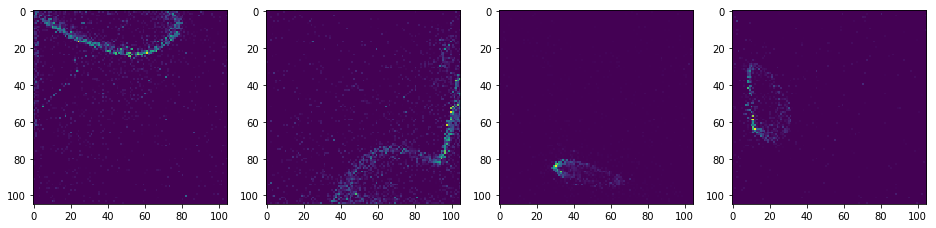

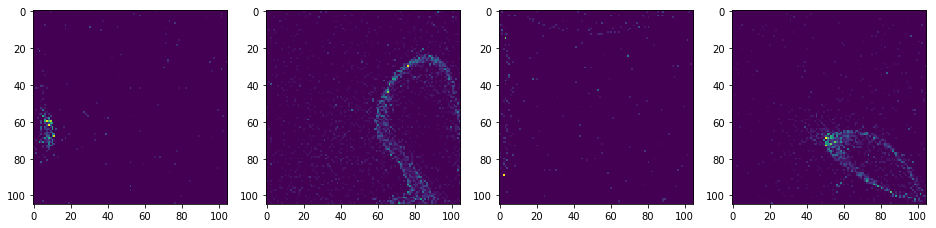

In [6]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data[0,:,:,0])
ax1.imshow(event_data[1,:,:,0])
ax2.imshow(event_data[2,:,:,0])
ax3.imshow(event_data[3,:,:,0])
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data[4,:,:,0])
ax1.imshow(event_data[5,:,:,0])
ax2.imshow(event_data[6,:,:,0])
ax3.imshow(event_data[7,:,:,0])
plt.show()

In [7]:
f1Re = h5py.File('/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat/1Re-blacksheet/wc-0-bch1.h5','r')
event_data_1Re = f1Re['event_data'][:]

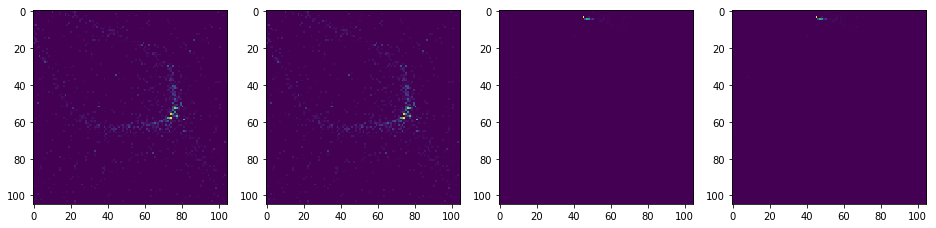

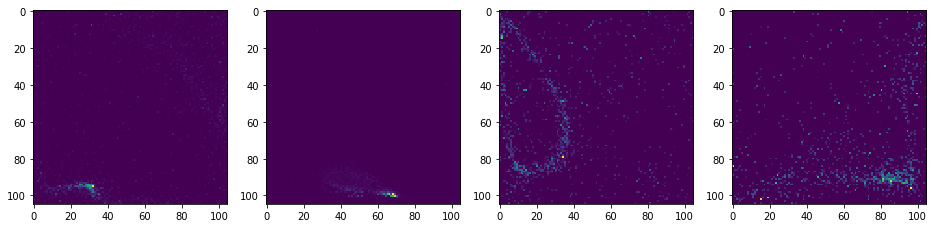

In [8]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Re[0,:,:,0])
ax1.imshow(event_data_1Re[1,:,:,0])
ax2.imshow(event_data_1Re[2,:,:,0])
ax3.imshow(event_data_1Re[3,:,:,0])
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Re[4,:,:,0])
ax1.imshow(event_data_1Re[5,:,:,0])
ax2.imshow(event_data_1Re[6,:,:,0])
ax3.imshow(event_data_1Re[7,:,:,0])
plt.show()

In [9]:
f1Rpip = h5py.File('/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat/1Rpip-blacksheet/wc-0-bch1.h5','r')
event_data_1Rpip = f1Rpip['event_data'][:]

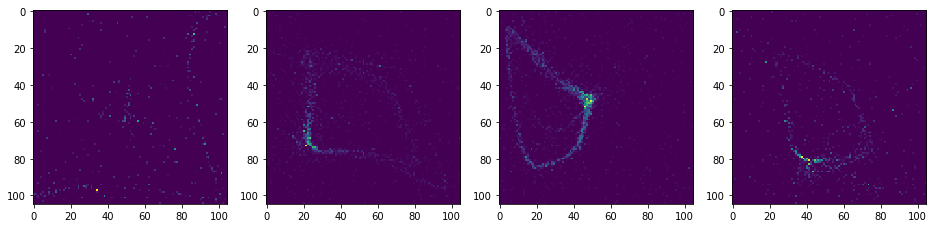

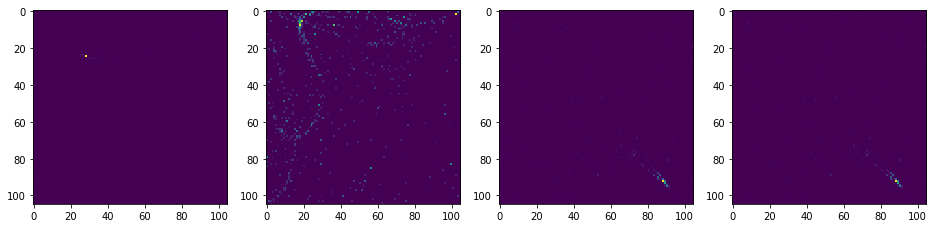

In [10]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Rpip[0,:,:,0])
ax1.imshow(event_data_1Rpip[1,:,:,0])
ax2.imshow(event_data_1Rpip[2,:,:,0])
ax3.imshow(event_data_1Rpip[3,:,:,0])
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(event_data_1Rpip[4,:,:,0])
ax1.imshow(event_data_1Rpip[5,:,:,0])
ax2.imshow(event_data_1Rpip[6,:,:,0])
ax3.imshow(event_data_1Rpip[7,:,:,0])
plt.show()

In [11]:
import torch 

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [12]:
# M: number of cols or rows grid

pad = 2

mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
  f['mGridX'][()],
  f['mGridY'][()],
  f['mGridZ'][()],
  f['mGridDirX'][()],
  f['mGridDirY'][()],
  f['mGridDirZ'][()]
])
Ncoords = mGridCoord.shape[0]

M = mGridPmt.shape[0]
mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
mGridJ = mGridI.transpose()

Nshift = 2*pad+1
dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
dis = dij.flatten()
djs = dij.transpose().flatten();
Nsites = dis.size;

mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


mGridAA2 = np.zeros((M,M,Nshift,Nshift,1+Ncoords)) # 1+Ncoords needs to be extended if we include 2nd order deriv

pmtI1 = mGridPmt[:,:]; # index in tank.pmt

x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

for diji in range(Nsites):
    di = dis[diji]
    dj = djs[diji]
    i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    pmtI2 = mGridPmtpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    processedPmtI2s[:,:,diji] = pmtI2;
    
    skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
    for prev_diji in range(diji):
        skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));
    
    x[:,:,:,diji] = mGridCoordPad[:,pad+di:pad+M+di,pad+dj:pad+M+dj] - mGridCoord; # 

# x: (Ncoords,M,M,Nsites)
print('x.shape:', x.shape)
# X: (Ntaylor,M,M,Nsites)    Ntaylor = 1 + Ncoords
X = np.concatenate([np.expand_dims(np.ones(x.shape[1:]),0),x])
print('X.shape:', X.shape)
X = np.where(np.expand_dims(skip, 0), 0., X);
# if we also do second derivatives, X needs to be extended by a x*x term

# regularization strength
Lambda = 1.; # this should be somewhat smaller than typical values of x

MA = np.zeros((M,M,Nsites,Nsites));
for k in range(Nsites):
    for j in range(Nsites):
        MA[:,:,k,j] = np.add(np.sum(x[:,:,:,k]*x[:,:,:,j], axis=0), 1. + Lambda**2 * (k==j));
    # clear skip entries
    MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
    MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
    # set diagonal:
    MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

#print('MA.shape:',MA.shape)
#print(MA[0,1,:,:])
#print(np.linalg.inv(MA[0,1,:,:]))
print("starting inversion... (may take a few seconds)")
AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
print("done")
print('AA.shape:', AA.shape)

x.shape: (6, 105, 105, 25)
X.shape: (7, 105, 105, 25)
starting inversion... (may take a few seconds)
done
AA.shape: (7, 105, 105, 25)


that was *way* faster

tGridAA.shape: torch.Size([7, 105, 105, 25])
tayloredInput.shape: torch.Size([5, 7, 1, 105, 105])
inputsPad.shape: torch.Size([5, 1, 109, 109])


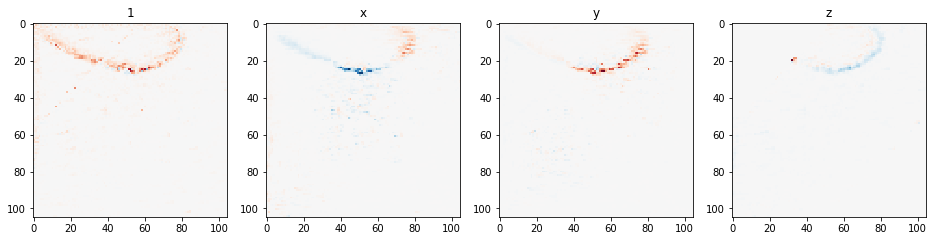

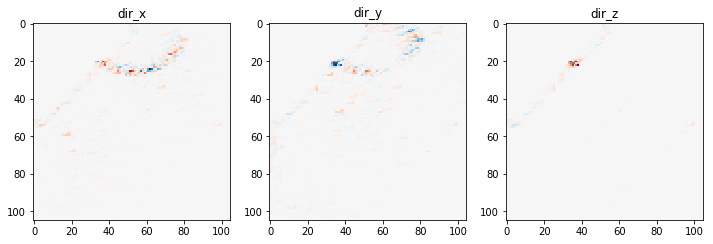

In [13]:
mGridAA = AA

Cin = 1; # Q
Hin = event_data.shape[1];
Win = event_data.shape[2];

# Cout = 4;
# Hflt = 2*pad+1;
# Wflt = 2*pad+1;

# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[0:5,:,:,0]).unsqueeze(1);
# outputs = torch.nn.functional.conv2d(geometricPad(inputs, pad), filters);

# print('filters.shape = ', filters.shape, 'should be (',Cout,',',Cin,',',Hflt,',',Wflt,')');
# print('inputs .shape = ', inputs.shape, 'should be (5,',Cin,',',Hin,',',Win,')');
# print('outputs.shape = ', outputs.shape, 'should be (5,',Cout,',',Hin,',',Win,')');

inputsPad = geometricPad(inputs, pad); # (B,C,W,H)

Nbatch = inputs.shape[0]
Ntaylor = 1 + Ncoords

tGridAA = torch.tensor(mGridAA, dtype=torch.float)

tayloredInput = torch.zeros((Nbatch,Ntaylor,Cin,Hin,Win))
print('tGridAA.shape:', tGridAA.shape)
print('tayloredInput.shape:', tayloredInput.shape)
print('inputsPad.shape:', inputsPad.shape)
for k in range(Ntaylor):
    # shift grid according to position (without copying the data)
    inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
    inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
    # fill
    out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
    tayloredInput = out

tayloredInput = tayloredInput.view(Nbatch, Ntaylor*Cin, Hin, Win)


def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)


ev=0
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[ev,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[ev,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[ev,3,:,:]); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,4,:,:]); ax0.set_title('dir_x')
imshowRdBu(ax1, tayloredInput[ev,5,:,:]); ax1.set_title('dir_y')
imshowRdBu(ax2, tayloredInput[ev,6,:,:]); ax2.set_title('dir_z')
plt.show()

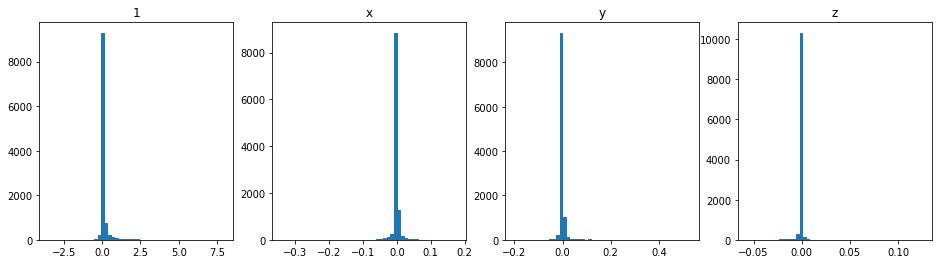

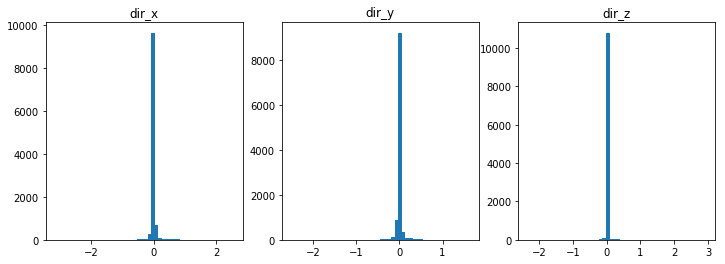

tensor([0.3840, 0.0151, 0.0236, 0.0029, 0.1265, 0.1072, 0.0731])


In [14]:
# plot distribution of values
coords_1d = tayloredInput[ev,:,:,:].reshape([tayloredInput.shape[1],-1])

# Make 1D histogram
ev=0
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,4),facecolor='w')
ax0.hist(coords_1d[0,:],bins=50); ax0.set_title('1')
ax1.hist(coords_1d[1,:],bins=50); ax1.set_title('x')
ax2.hist(coords_1d[2,:],bins=50); ax2.set_title('y')
ax3.hist(coords_1d[3,:],bins=50); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,4),facecolor='w')
ax0.hist(coords_1d[4,:],bins=50); ax0.set_title('dir_x')
ax1.hist(coords_1d[5,:],bins=50); ax1.set_title('dir_y')
ax2.hist(coords_1d[6,:],bins=50); ax2.set_title('dir_z')
plt.show()

print(torch.std(coords_1d,1))

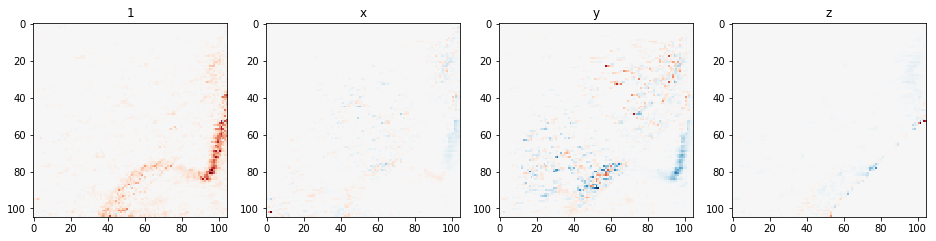

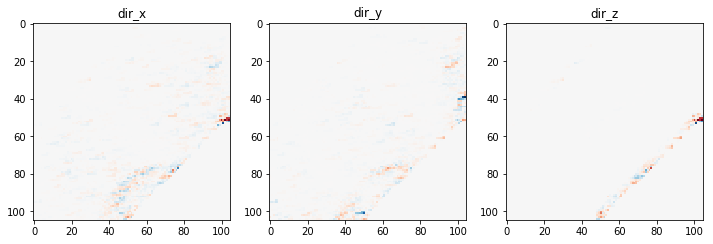

In [15]:
ev=1
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[ev,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[ev,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[ev,3,:,:]); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,4,:,:]); ax0.set_title('dir_x')
imshowRdBu(ax1, tayloredInput[ev,5,:,:]); ax1.set_title('dir_y')
imshowRdBu(ax2, tayloredInput[ev,6,:,:]); ax2.set_title('dir_z')
plt.show()

In [16]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin*Ntaylor,Cout,1)
        self.AA = tGridAA.clone()
        # 1x1 convolution since the neighbor information is encoded in the additional channels out Ntaylor
 
    def forward(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        tayloredInput = x.new_zeros((Nbatch,Ntaylor,self.Cin,Hin,Win))
        for k in range(Ntaylor):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', self.AA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        tayloredInput = tayloredInput.view(Nbatch, Ntaylor*self.Cin, Hin, Win)
        return self.conv2d(tayloredInput)
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.AA.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.AA = self.AA.cuda()
        return self


class GeomConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(GeomConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*pad+1)
 
    def forward(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        return self.conv2d(inputsPad)


class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            #TaylorConv2d( 2,16), torch.nn.ReLU(),
            #TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(CNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(CNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [17]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(3).cuda() # construct CNN for 3 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [18]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

H5Dataset from https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20DataLoader.ipynb

In [19]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        return fh['event_data'][entry_index],label,idx
        #return fh['event_data'][entry_index],np.stack([np.sum(fh['energies'][entry_index,:])]),idx
        #labels = (fh['energies'][entry_index,0]>500.)-0
        #return fh['event_data'][entry_index],labels,idx

In [20]:
#f.close()
#f1Re.close()
#f1Rpip.close()

7500 total events are loaded!
Entry 0 ... label: 0 ... data shape: (105, 105, 2)


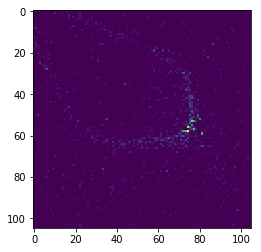

In [21]:
mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
ds = H5Dataset(['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(5) for pname in pnames])
print(len(ds),'total events are loaded!')

ENTRY = 0
# Access an index
data,label,idx = ds[ENTRY]
# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
# Visualize
plt.imshow(data[:,:,0])
plt.show()

In [22]:
def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [23]:
loader = DataLoader(ds,
                    batch_size=5,  # set the batch size = 50
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )
#time_record = loop(loader,10)
#print('Overall average iteration time:',time_record.mean(),'[s]')
#print('First event     iteration time:',time_record[0],    '[s]')
#print('After first event average time:',time_record[1:].mean(),'[s]')

(5, 105, 105, 2) [0, 0, 1, 2, 2]


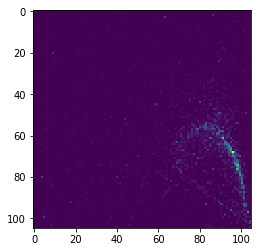

In [24]:
for i,data in enumerate(loader):
    break

print(data[0].shape, data[1])

plt.imshow(data[0][0,:,:,0])
plt.show()

In [25]:
import time

# Set the network to training mode
blob.net.train()
train_loader = loader

# Start training
for i,data in enumerate(train_loader):
    break

# Data and label
blob.data,blob.label = data[0:2]
# Call forward: make a prediction & measure the average error
res = forward(blob,True)
# Call backward: backpropagate error and update weights


In [26]:
res

{'prediction': array([1, 1, 1, 1, 1]),
 'softmax': array([[8.6714799e-08, 9.9587137e-01, 4.1285120e-03],
        [3.1997092e-04, 9.1607583e-01, 8.3604187e-02],
        [4.3969590e-04, 9.0318704e-01, 9.6373275e-02],
        [3.6246856e-03, 8.2532763e-01, 1.7104766e-01],
        [3.7972941e-07, 9.9035454e-01, 9.6450606e-03]], dtype=float32),
 'loss': 3.0288619995117188,
 'accuracy': 0.2}

In [27]:
blob.optimizer.zero_grad()  # Reset gradients accumulation
#blob.loss.backward()
#blob.optimizer.step()

In [28]:
blob.loss.backward()

In [29]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [30]:
mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(5) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [51]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-17 14:04:32


Epoch 1 Starting @ 2019-08-17 14:04:37


Epoch 2 Starting @ 2019-08-17 14:04:42


Unknown label 0 for entry_index 223 treating as label=0
Epoch 3 Starting @ 2019-08-17 14:04:47


Epoch 4 Starting @ 2019-08-17 14:04:52


Epoch 5 Starting @ 2019-08-17 14:04:56


Unknown label 0 for entry_index 478 treating as label=0
Epoch 6 Starting @ 2019-08-17 14:05:01


Epoch 7 Starting @ 2019-08-17 14:05:06


Unknown label 0 for entry_index 365 treating as label=0
Epoch 8 Starting @ 2019-08-17 14:05:11


Unknown label 0 for entry_index 145 treating as label=0
Epoch 9 Starting @ 2019-08-17 14:05:16


Unknown label 0 for entry_index 291 treating as label=0


In [52]:
blob.test_log.close()
blob.train_log.close()

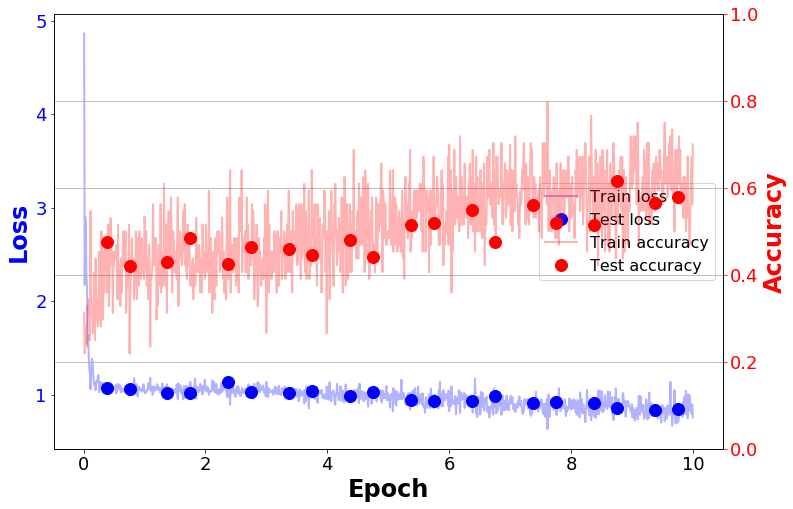

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

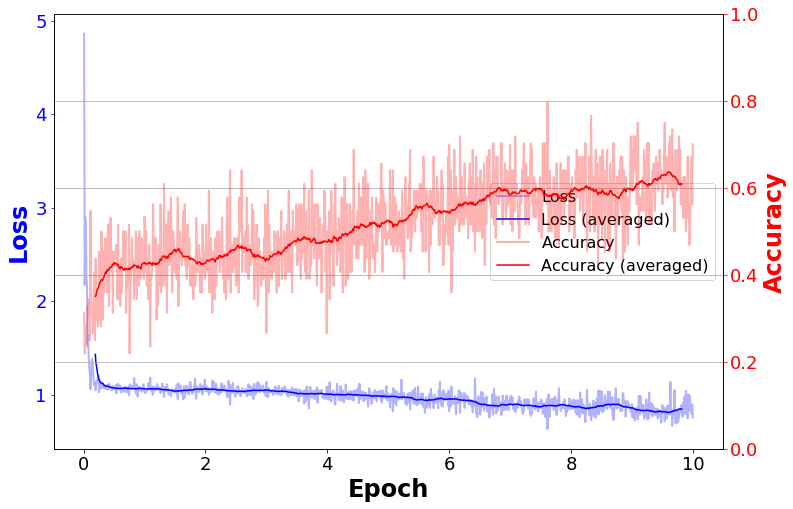

In [54]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [55]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Accuracy mean 0.58875 std 0.03379626


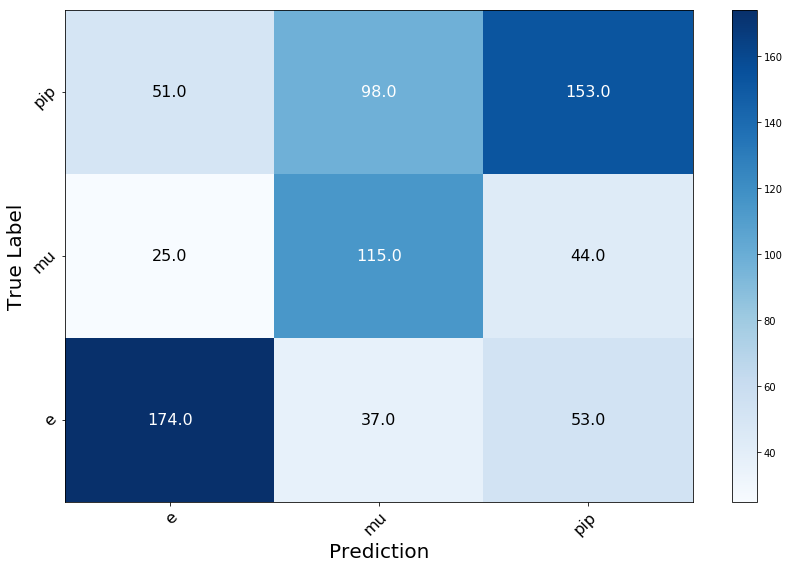

In [57]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu','pip'])

I think "True Label" and "Prediction" is swapped

In [37]:
class GeomCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(GeomCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            #TaylorConv2d( 2,16), torch.nn.ReLU(),
            #TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            GeomConv2d( 2,16), torch.nn.ReLU(),
            GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(GeomCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(GeomCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [38]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = GeomCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [39]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-17 21:30:40


Epoch 1 Starting @ 2019-08-17 21:30:46


Epoch 2 Starting @ 2019-08-17 21:30:52


Epoch 3 Starting @ 2019-08-17 21:30:58


Epoch 4 Starting @ 2019-08-17 21:31:04


Epoch 5 Starting @ 2019-08-17 21:31:11


Epoch 6 Starting @ 2019-08-17 21:31:17


Epoch 7 Starting @ 2019-08-17 21:31:23


Epoch 8 Starting @ 2019-08-17 21:31:29


Epoch 9 Starting @ 2019-08-17 21:31:36


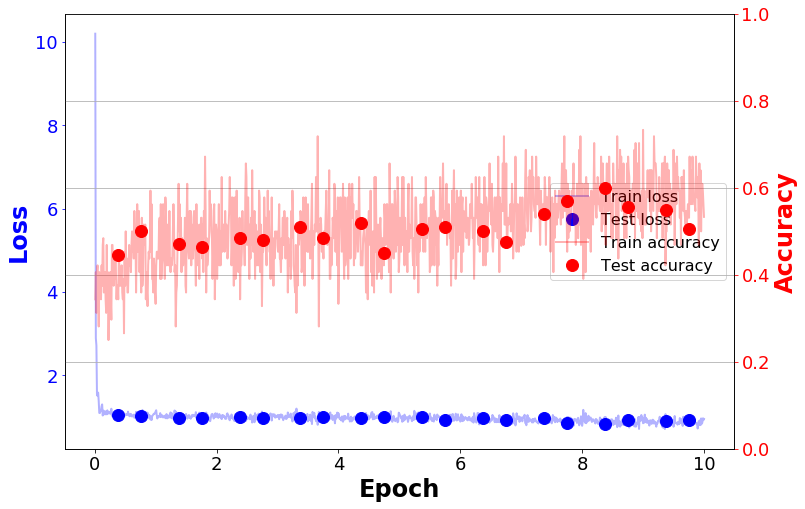

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

Accuracy mean 0.5608333 std 0.027118564


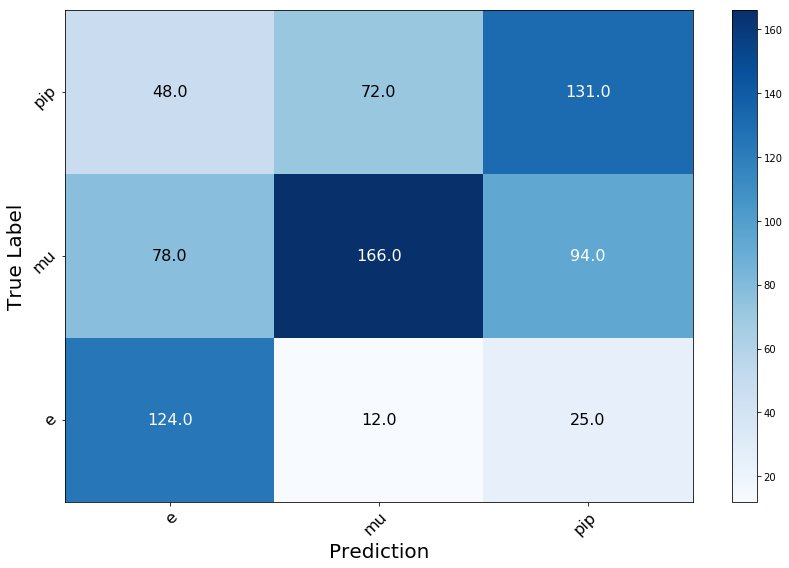

In [66]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu','pip'])

In [74]:
blob.net._feature.parameters()

<generator object Module.parameters at 0x2b3cab83ee08>

In [83]:
# https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


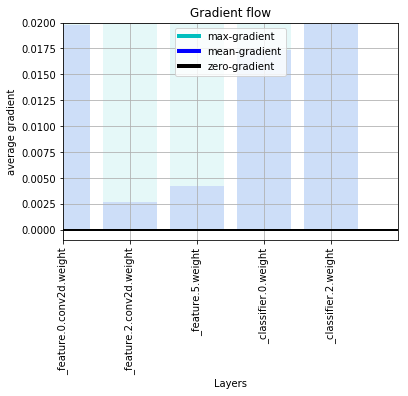

In [84]:
plot_grad_flow(blob.net.named_parameters())

In [89]:
for name,param in blob.net.named_parameters():
  print(name, param.data.shape)

_feature.0.conv2d.weight torch.Size([16, 2, 5, 5])
_feature.0.conv2d.bias torch.Size([16])
_feature.2.conv2d.weight torch.Size([32, 16, 5, 5])
_feature.2.conv2d.bias torch.Size([32])
_feature.5.weight torch.Size([32, 32, 3, 3])
_feature.5.bias torch.Size([32])
_classifier.0.weight torch.Size([32, 32])
_classifier.0.bias torch.Size([32])
_classifier.2.weight torch.Size([3, 32])
_classifier.2.bias torch.Size([3])


In [92]:
class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(TaylorCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            TaylorConv2d( 2,16), torch.nn.ReLU(),
            TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [96]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [97]:
for name,param in blob.net.named_parameters():
  print(name, param.data.shape)

_feature.0.conv2d.weight torch.Size([16, 14, 1, 1])
_feature.0.conv2d.bias torch.Size([16])
_feature.2.conv2d.weight torch.Size([32, 112, 1, 1])
_feature.2.conv2d.bias torch.Size([32])
_feature.5.weight torch.Size([32, 32, 3, 3])
_feature.5.bias torch.Size([32])
_classifier.0.weight torch.Size([32, 32])
_classifier.0.bias torch.Size([32])
_classifier.2.weight torch.Size([3, 32])
_classifier.2.bias torch.Size([3])


In [98]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-17 14:32:59


Epoch 1 Starting @ 2019-08-17 14:33:17


Epoch 2 Starting @ 2019-08-17 14:33:35


Epoch 3 Starting @ 2019-08-17 14:33:52


Epoch 4 Starting @ 2019-08-17 14:34:10


Epoch 5 Starting @ 2019-08-17 14:34:27


Epoch 6 Starting @ 2019-08-17 14:34:45


Epoch 7 Starting @ 2019-08-17 14:35:03


Unknown label 0 for entry_index 122 treating as label=0
Epoch 8 Starting @ 2019-08-17 14:35:20


Epoch 9 Starting @ 2019-08-17 14:35:38


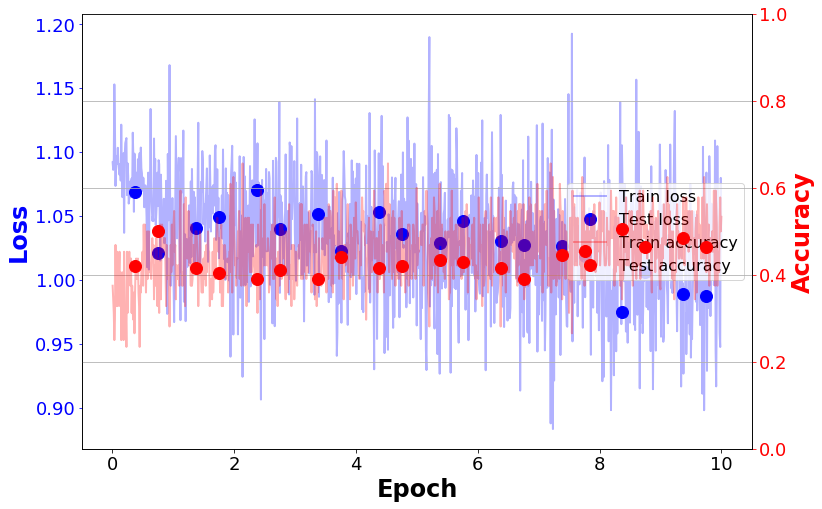

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

scale the output of the multiplication by taylor such that we get mostly uniform values

In [35]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin*Ntaylor,Cout,1)
        self.AA = tGridAA.clone()
        self.AA[0,:,:]   *= 1.
        self.AA[1:3,:,:] *= 20.
        self.AA[4:6,:,:] *=  2.
        # 1x1 convolution since the neighbor information is encoded in the additional channels out Ntaylor
 
    def forward(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        tayloredInput = x.new_zeros((Nbatch,Ntaylor,self.Cin,Hin,Win))
        for k in range(Ntaylor):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', self.AA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        tayloredInput = tayloredInput.view(Nbatch, Ntaylor*self.Cin, Hin, Win)
        return self.conv2d(tayloredInput)
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.AA = self.AA.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.AA = self.AA.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(TaylorCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            TaylorConv2d( 2,16), torch.nn.ReLU(),
            TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [32]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [33]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-18 01:34:55


Unknown label 0 for entry_index 462 treating as label=0
Epoch 1 Starting @ 2019-08-18 01:35:13


Epoch 2 Starting @ 2019-08-18 01:35:31


Epoch 3 Starting @ 2019-08-18 01:35:48


Epoch 4 Starting @ 2019-08-18 01:36:06


Unknown label 0 for entry_index 164 treating as label=0
Unknown label 0 for entry_index 464 treating as label=0
Epoch 5 Starting @ 2019-08-18 01:36:23


Unknown label 0 for entry_index 476 treating as label=0
Epoch 6 Starting @ 2019-08-18 01:36:41


Epoch 7 Starting @ 2019-08-18 01:36:59


Epoch 8 Starting @ 2019-08-18 01:37:16


Epoch 9 Starting @ 2019-08-18 01:37:34


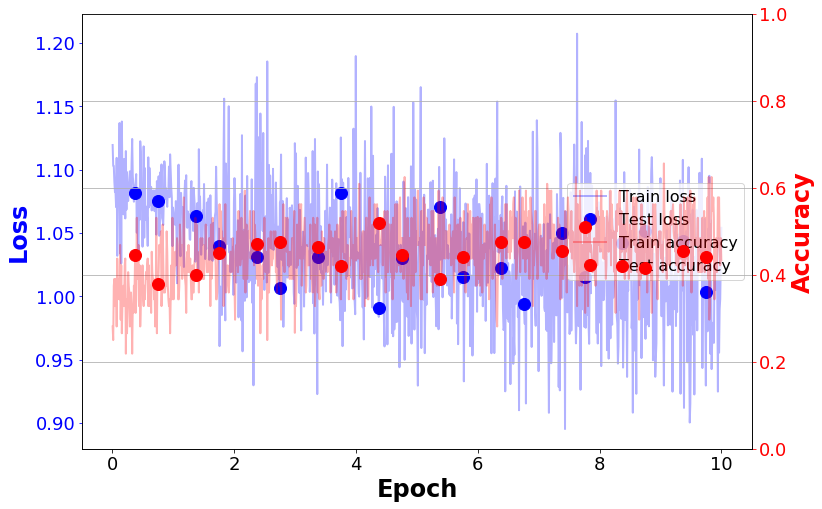

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [38]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    res = forward(blob,False)
    print(blob.label)
    print(res)

[2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 1, 1]
{'prediction': array([2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 2,
       2, 1, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0,
       2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2,
       2, 1, 0, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 0, 0, 0, 1, 1,
       0, 0, 0, 2, 

In [49]:
for name,par in blob.net.named_parameters():
    print(name, torch.mean(par.grad).cpu().numpy())

_feature.0.conv2d.weight -0.00027799723
_feature.0.conv2d.bias 8.7104934e-05
_feature.2.conv2d.weight -0.00013598948
_feature.2.conv2d.bias 0.000570306
_feature.5.weight -0.0002771562
_feature.5.bias -0.0005158367
_classifier.0.weight 0.0008140223
_classifier.0.bias 0.0013366219
_classifier.2.weight -1.1527088e-09
_classifier.2.bias 0.0


In [50]:
for name,par in blob.net.named_parameters():
    print(name, torch.mean(par.data).cpu().numpy())

_feature.0.conv2d.weight -0.00048176147
_feature.0.conv2d.bias -0.06892258
_feature.2.conv2d.weight 0.0016952194
_feature.2.conv2d.bias -0.060845986
_feature.5.weight -0.0062736976
_feature.5.bias 0.0072150975
_classifier.0.weight -0.0011168462
_classifier.0.bias -0.009140315
_classifier.2.weight 0.009387428
_classifier.2.bias -0.048561186


torch.Size([200, 16, 105, 105])


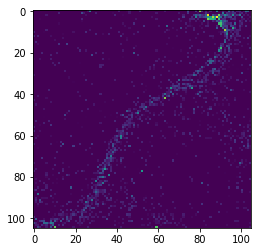

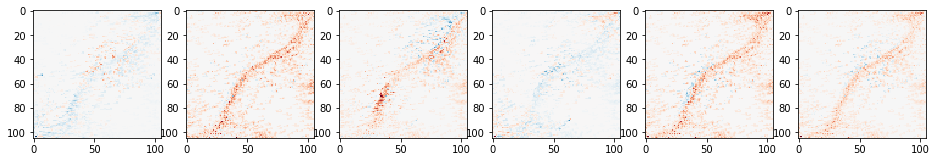

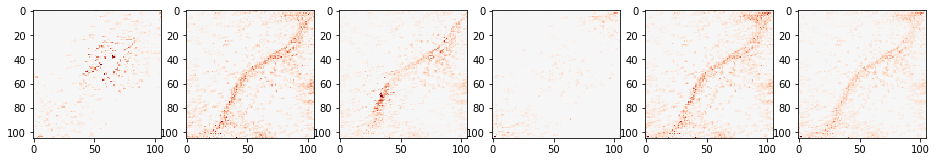

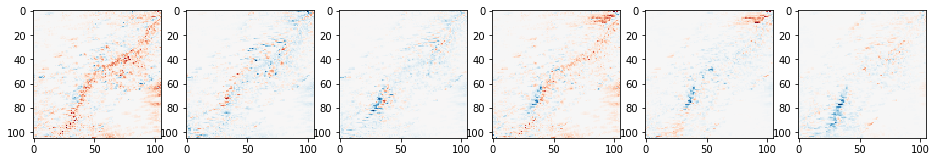

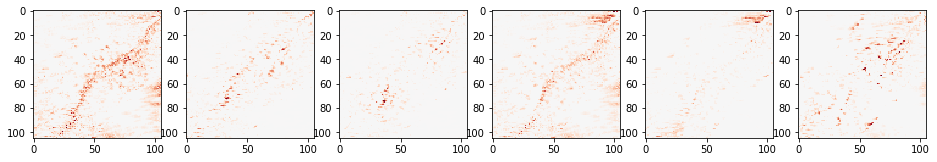

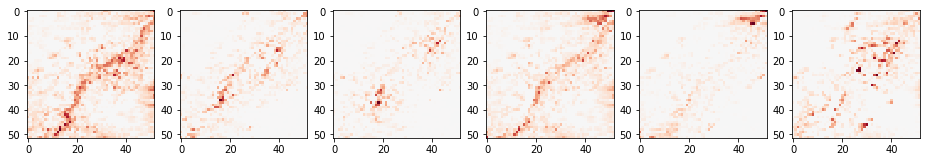

In [66]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    feature0 = blob.net._feature[0](data)
    feature1 = blob.net._feature[1](feature0)
    feature2 = blob.net._feature[2](feature1)
    feature3 = blob.net._feature[3](feature2)
    feature4 = blob.net._feature[4](feature3)
    print(feature1.shape)
    
    ev=1
    
    plt.imshow(data[ev,0,:,:].cpu())
    plt.show()
    
    fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, feature0[ev,0,:,:].cpu())
    imshowRdBu(ax1, feature0[ev,1,:,:].cpu())
    imshowRdBu(ax2, feature0[ev,2,:,:].cpu())
    imshowRdBu(ax3, feature0[ev,3,:,:].cpu())
    imshowRdBu(ax4, feature0[ev,4,:,:].cpu())
    imshowRdBu(ax5, feature0[ev,5,:,:].cpu())
    plt.show()
    
    fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, feature1[ev,0,:,:].cpu())
    imshowRdBu(ax1, feature1[ev,1,:,:].cpu())
    imshowRdBu(ax2, feature1[ev,2,:,:].cpu())
    imshowRdBu(ax3, feature1[ev,3,:,:].cpu())
    imshowRdBu(ax4, feature1[ev,4,:,:].cpu())
    imshowRdBu(ax5, feature1[ev,5,:,:].cpu())
    plt.show()
    
    fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, feature2[ev,0,:,:].cpu())
    imshowRdBu(ax1, feature2[ev,1,:,:].cpu())
    imshowRdBu(ax2, feature2[ev,2,:,:].cpu())
    imshowRdBu(ax3, feature2[ev,3,:,:].cpu())
    imshowRdBu(ax4, feature2[ev,4,:,:].cpu())
    imshowRdBu(ax5, feature2[ev,5,:,:].cpu())
    plt.show()
    
    fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, feature3[ev,0,:,:].cpu())
    imshowRdBu(ax1, feature3[ev,1,:,:].cpu())
    imshowRdBu(ax2, feature3[ev,2,:,:].cpu())
    imshowRdBu(ax3, feature3[ev,3,:,:].cpu())
    imshowRdBu(ax4, feature3[ev,4,:,:].cpu())
    imshowRdBu(ax5, feature3[ev,5,:,:].cpu())
    plt.show()
    
    fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, feature4[ev,0,:,:].cpu())
    imshowRdBu(ax1, feature4[ev,1,:,:].cpu())
    imshowRdBu(ax2, feature4[ev,2,:,:].cpu())
    imshowRdBu(ax3, feature4[ev,3,:,:].cpu())
    imshowRdBu(ax4, feature4[ev,4,:,:].cpu())
    imshowRdBu(ax5, feature4[ev,5,:,:].cpu())
    plt.show()

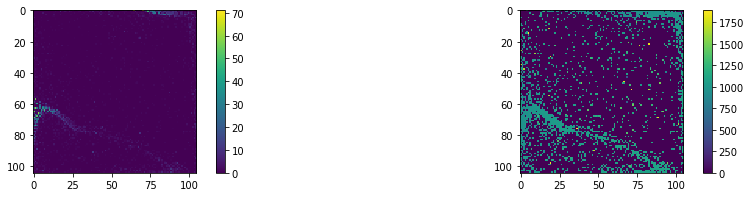

_feature 0 TaylorConv2d(
  (conv2d): Conv2d(14, 16, kernel_size=(1, 1), stride=(1, 1))
)


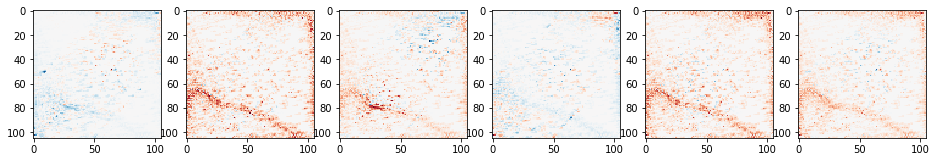

_feature 1 ReLU()


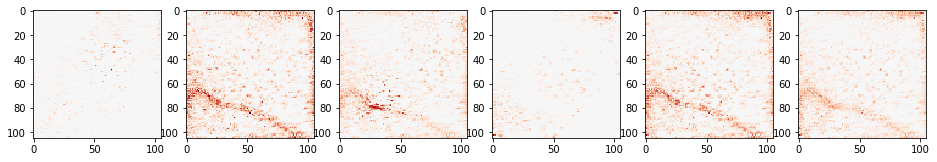

_feature 2 TaylorConv2d(
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)


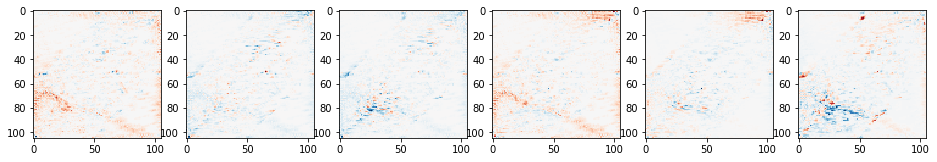

_feature 3 ReLU()


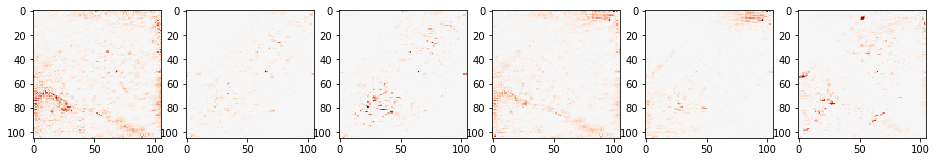

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


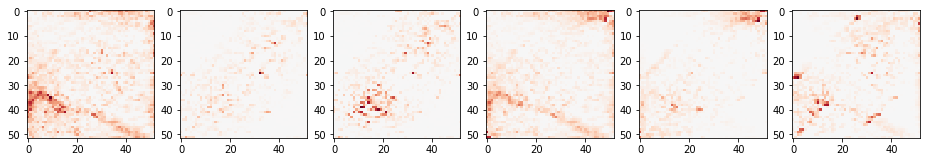

_feature 5 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


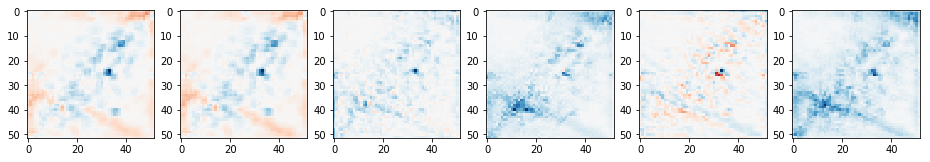

_feature 6 ReLU()


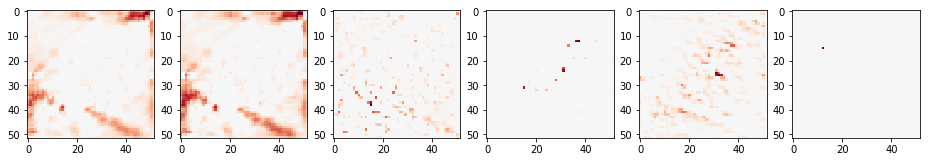

torch.Size([200, 32, 52, 52]) after _feature
torch.Size([200, 32, 1, 1]) after AvgPool2d
torch.Size([200, 32]) after view(-1,32)


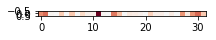

_classifier 0 Linear(in_features=32, out_features=32, bias=True)


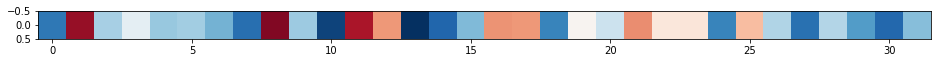

_classifier 1 ReLU()


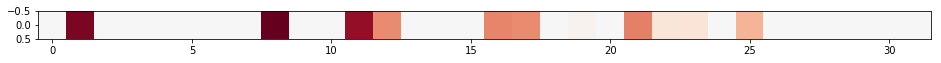

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


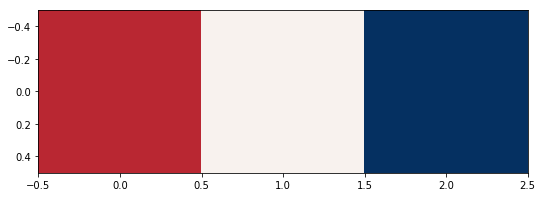

In [80]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    im = ax1.imshow(data[ev,1,:,:].cpu())
    cbar = ax1.figure.colorbar(im, ax=ax1)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        x = module(x)
        fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,0,:,:].cpu())
        imshowRdBu(ax1, x[ev,1,:,:].cpu())
        imshowRdBu(ax2, x[ev,2,:,:].cpu())
        imshowRdBu(ax3, x[ev,3,:,:].cpu())
        imshowRdBu(ax4, x[ev,4,:,:].cpu())
        imshowRdBu(ax5, x[ev,5,:,:].cpu())
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,32)
    print(x.shape, 'after view(-1,32)')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

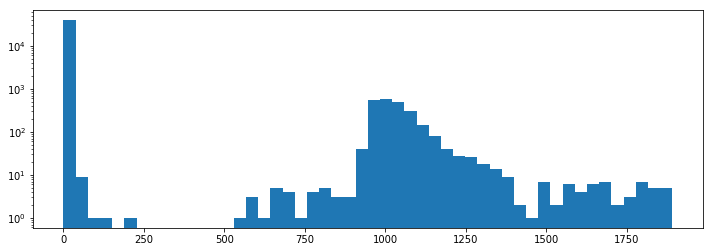

In [85]:
# plot time distribution
coords_1d = blob.data[:,1,:,:].reshape(-1)

# Make 1D histogram
fig, (ax0) = plt.subplots(1, 1, figsize=(12,4),facecolor='w')
ax0.hist(coords_1d,bins=50)
plt.yscale('log')
plt.show()

let's subtract 900 ns from the time where charge is nonzero

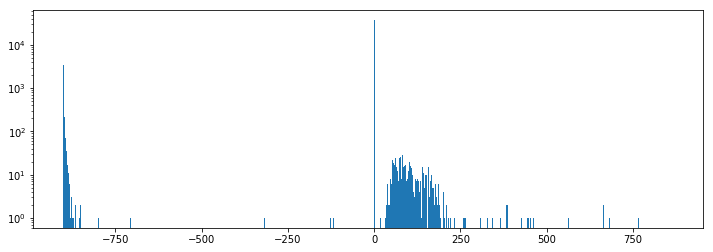

In [98]:
# plot time distribution
coords_1d = np.where(blob.data[:,0,:,:] > 0, blob.data[:,1,:,:]-900, blob.data[:,1,:,:]*0.).reshape(-1)

# Make 1D histogram
fig, (ax0) = plt.subplots(1, 1, figsize=(12,4),facecolor='w')
ax0.hist(coords_1d,bins=1000)
plt.yscale('log')
plt.show()

In [31]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        event_data[:,:,1] = np.where(event_data[:,:,0] > 0., event_data[:,:,1]-900., 0.)
        return event_data,label,idx
        #return fh['event_data'][entry_index],np.stack([np.sum(fh['energies'][entry_index,:])]),idx
        #labels = (fh['energies'][entry_index,0]>500.)-0
        #return fh['event_data'][entry_index],labels,idx

In [32]:
mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(5) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

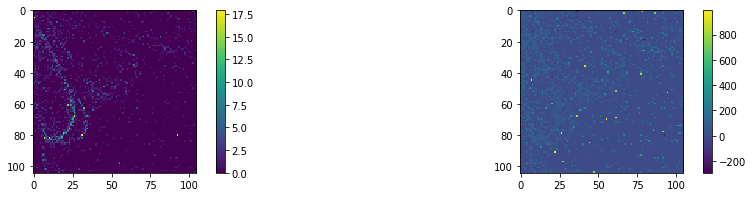

In [34]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    im = ax1.imshow(data[ev,1,:,:].cpu())
    cbar = ax1.figure.colorbar(im, ax=ax1)
    plt.show()

In [36]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin*Ntaylor,Cout,1)
        self.AA = tGridAA.clone()
        self.AA[0,:,:]   *= 1.
        self.AA[1:3,:,:] *= 20.
        self.AA[4:6,:,:] *=  2.
        # 1x1 convolution since the neighbor information is encoded in the additional channels out Ntaylor
 
    def forward(self, x):
        return self.conv2d(self.taylor(x))
    
    def taylor(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        tayloredInput = x.new_zeros((Nbatch,Ntaylor,self.Cin,Hin,Win))
        for k in range(Ntaylor):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', self.AA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        return tayloredInput.view(Nbatch, Ntaylor*self.Cin, Hin, Win)
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.AA = self.AA.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.AA = self.AA.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(TaylorCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            TaylorConv2d( 2,16), torch.nn.ReLU(),
            TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [37]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [38]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-18 11:33:32


Epoch 1 Starting @ 2019-08-18 11:33:50


Epoch 2 Starting @ 2019-08-18 11:34:07


Unknown label 0 for entry_index 497 treating as label=0


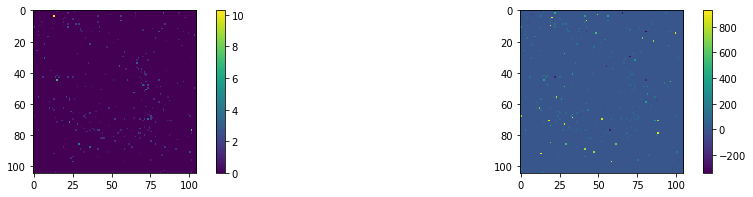

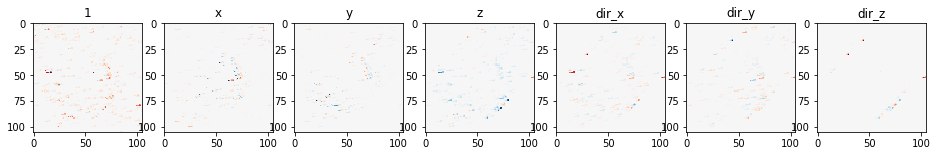

_feature 0 TaylorConv2d(
  (conv2d): Conv2d(14, 16, kernel_size=(1, 1), stride=(1, 1))
)


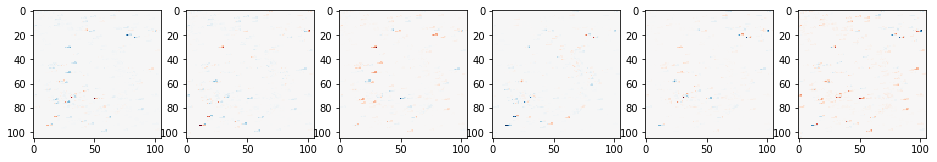

_feature 1 ReLU()


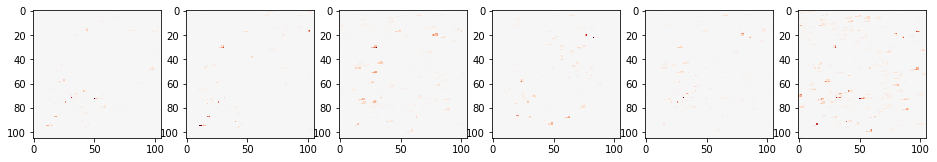

_feature 2 TaylorConv2d(
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)


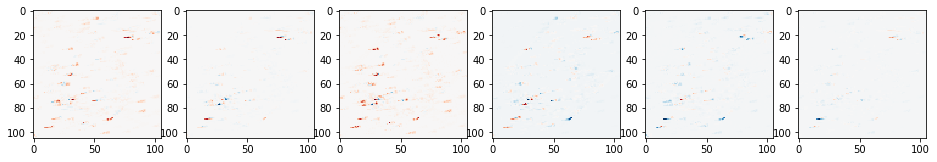

_feature 3 ReLU()


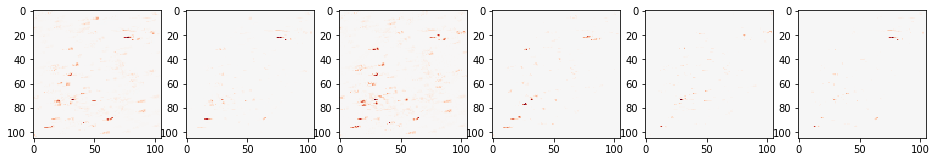

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


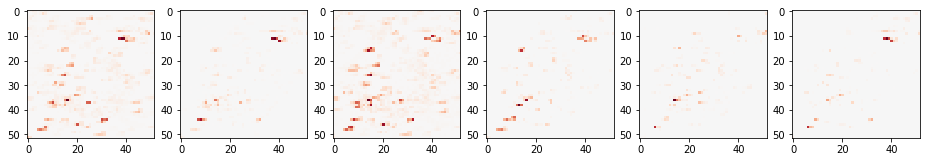

_feature 5 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


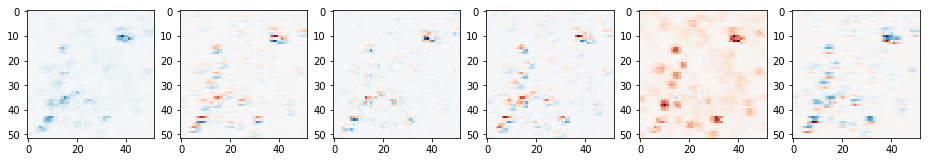

_feature 6 ReLU()


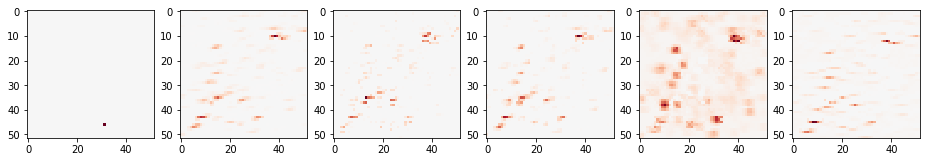

In [39]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    im = ax1.imshow(data[ev,1,:,:].cpu())
    cbar = ax1.figure.colorbar(im, ax=ax1)
    plt.show()
    
    tayloredInput = blob.net._feature[0].taylor(data)
    fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, tayloredInput[ev,2*0,:,:].cpu()); ax0.set_title('1')
    imshowRdBu(ax1, tayloredInput[ev,2*1,:,:].cpu()); ax1.set_title('x')
    imshowRdBu(ax2, tayloredInput[ev,2*2,:,:].cpu()); ax2.set_title('y')
    imshowRdBu(ax3, tayloredInput[ev,2*3,:,:].cpu()); ax3.set_title('z')
    imshowRdBu(ax4, tayloredInput[ev,2*4,:,:].cpu()); ax4.set_title('dir_x')
    imshowRdBu(ax5, tayloredInput[ev,2*5,:,:].cpu()); ax5.set_title('dir_y')
    imshowRdBu(ax6, tayloredInput[ev,2*6,:,:].cpu()); ax6.set_title('dir_z')
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        x = module(x)
        fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,0,:,:].cpu())
        imshowRdBu(ax1, x[ev,1,:,:].cpu())
        imshowRdBu(ax2, x[ev,2,:,:].cpu())
        imshowRdBu(ax3, x[ev,3,:,:].cpu())
        imshowRdBu(ax4, x[ev,4,:,:].cpu())
        imshowRdBu(ax5, x[ev,5,:,:].cpu())
        plt.show()
    
    # # next the classifier
    # print(x.shape, 'after _feature')
    # x = torch.nn.AvgPool2d(x.size()[2:])(x)
    # print(x.shape, 'after AvgPool2d')
    # x = x.view(-1,32)
    # print(x.shape, 'after view(-1,32)')
    # 
    # fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    # imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    # plt.show()
    # 
    # for i,module in enumerate(blob.net._classifier):
    #     print('_classifier', i, module)
    #     x = module(x)
    #     fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    #     imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    #     plt.show()

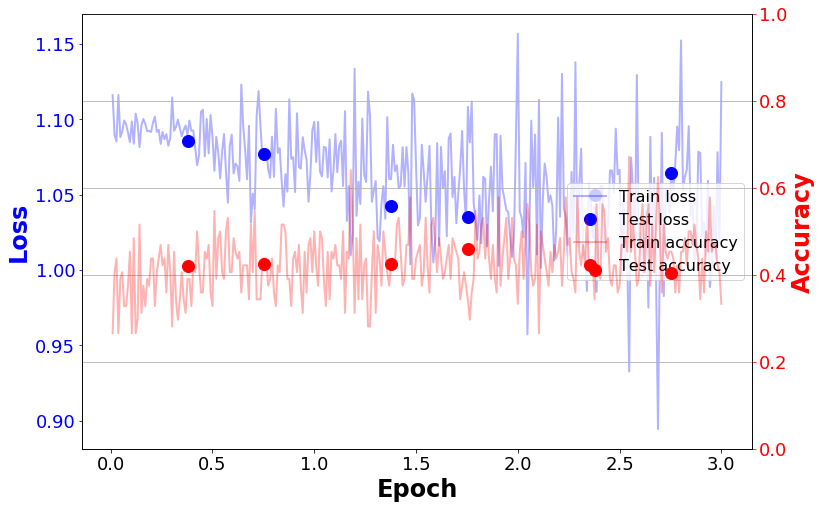

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

## Deeper layers

In [41]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin*Ntaylor,Cout,1)
        self.AA = tGridAA.clone()
        self.AA[0,:,:]   *= 1.
        self.AA[1:3,:,:] *= 20.
        self.AA[4:6,:,:] *=  2.
        # 1x1 convolution since the neighbor information is encoded in the additional channels out Ntaylor
 
    def forward(self, x):
        return self.conv2d(self.taylor(x))
    
    def taylor(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        tayloredInput = x.new_zeros((Nbatch,Ntaylor,self.Cin,Hin,Win))
        for k in range(Ntaylor):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', self.AA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        return tayloredInput.view(Nbatch, Ntaylor*self.Cin, Hin, Win)
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.AA = self.AA.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.AA = self.AA.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(TaylorCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            TaylorConv2d( 2,16), torch.nn.ReLU(),
            TaylorConv2d(16,32), torch.nn.ReLU(),
            
            # geom conv
            #GeomConv2d( 2,16), torch.nn.ReLU(),
            #GeomConv2d(16,32), torch.nn.ReLU(),
            
            # ordinary conv
            #torch.nn.Conv2d( 2,16,3,padding=1), torch.nn.ReLU(),
            #torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            GeomConv2d(32,32), torch.nn.ReLU(),
            GeomConv2d(32,32), torch.nn.ReLU(),
            # B,C=32,H=63,W=63
            
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=32,W=32
            GeomConv2d(32,64), torch.nn.ReLU(),
            # B,C=64,H=32,W=32
            GeomConv2d(64,64), torch.nn.ReLU(),
            # B,C=64,H=32,W=32
            
            torch.nn.MaxPool2d(2,2),
            # B,C=64,H=16,W=16
            GeomConv2d(64,128), torch.nn.ReLU(),
            # B,C=128,H=16,W=16
            GeomConv2d(128,128), torch.nn.ReLU(),
            # B,C=128,H=16,W=16
            
            torch.nn.MaxPool2d(2,2),
            # B,C=64,H=8,W=8
            GeomConv2d(128,256), torch.nn.ReLU(),
            # B,C=256,H=8,W=8
            GeomConv2d(256,256), torch.nn.ReLU()
            # B,C=256,H=8,W=8
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,256))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [42]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [43]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-18 11:37:31


Epoch 1 Starting @ 2019-08-18 11:37:54


Epoch 2 Starting @ 2019-08-18 11:38:18


Unknown label 0 for entry_index 237 treating as label=0


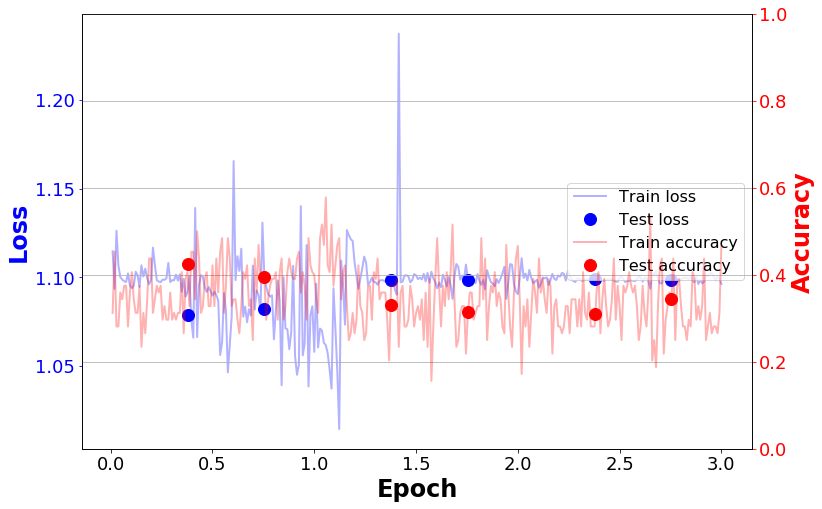

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

doesn't seem to be learning, use GeomConv instead

In [45]:
class GeomCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(GeomCNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            
            # taylor conv
            GeomConv2d( 2,16), torch.nn.ReLU(),
            GeomConv2d(16,32), torch.nn.ReLU(),
            
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            GeomConv2d(32,32), torch.nn.ReLU(),
            GeomConv2d(32,32), torch.nn.ReLU(),
            # B,C=32,H=63,W=63
            
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=32,W=32
            GeomConv2d(32,64), torch.nn.ReLU(),
            # B,C=64,H=32,W=32
            GeomConv2d(64,64), torch.nn.ReLU(),
            # B,C=64,H=32,W=32
            
            torch.nn.MaxPool2d(2,2),
            # B,C=64,H=16,W=16
            GeomConv2d(64,128), torch.nn.ReLU(),
            # B,C=128,H=16,W=16
            GeomConv2d(128,128), torch.nn.ReLU(),
            # B,C=128,H=16,W=16
            
            torch.nn.MaxPool2d(2,2),
            # B,C=64,H=8,W=8
            GeomConv2d(128,256), torch.nn.ReLU(),
            # B,C=256,H=8,W=8
            GeomConv2d(256,256), torch.nn.ReLU()
            # B,C=256,H=8,W=8
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,256))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(GeomCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(GeomCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [56]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = GeomCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [57]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-18 14:33:20


Epoch 1 Starting @ 2019-08-18 14:34:11


Epoch 2 Starting @ 2019-08-18 14:35:00


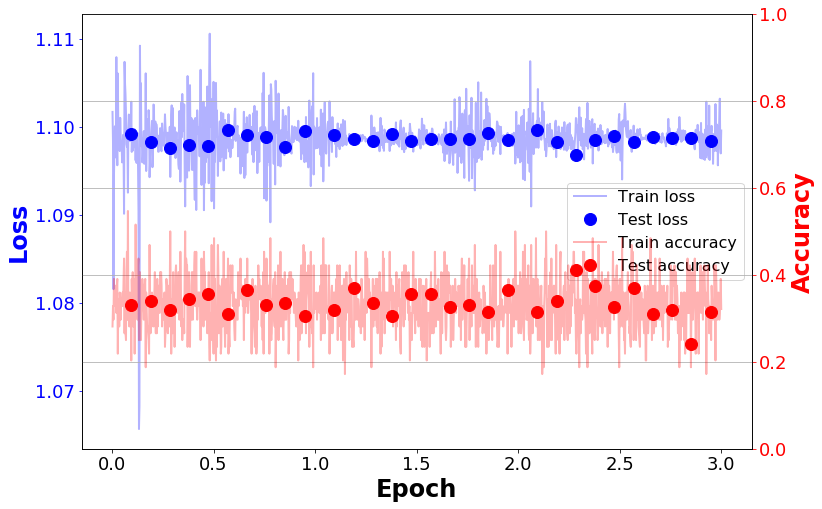

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

let's train more epochs

In [ ]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

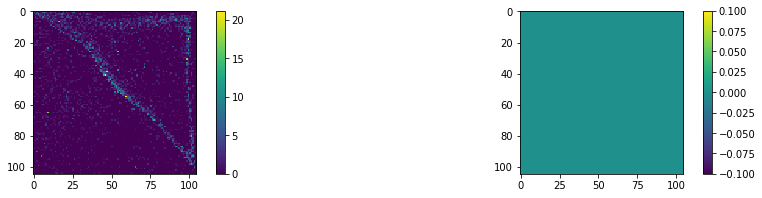

_feature 0 GeomConv2d(
  (conv2d): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
)


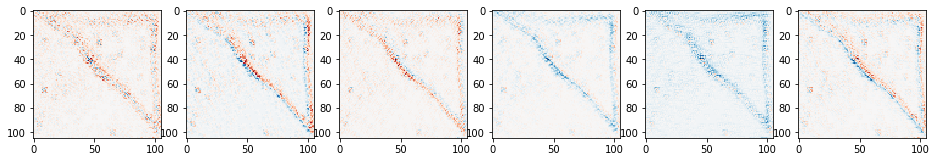

_feature 1 ReLU()


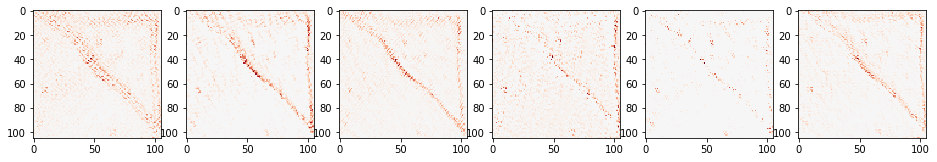

_feature 2 GeomConv2d(
  (conv2d): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
)


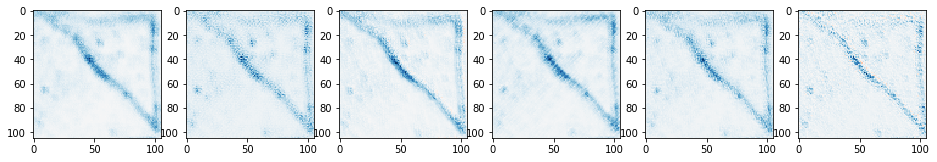

_feature 3 ReLU()


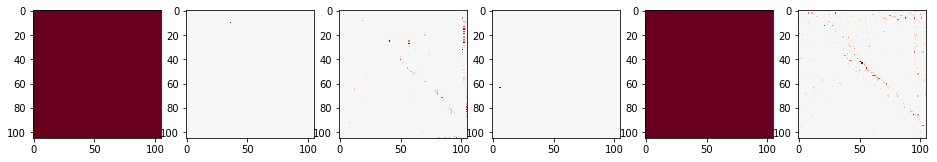

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


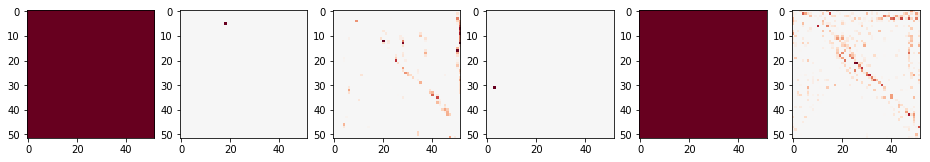

_feature 5 GeomConv2d(
  (conv2d): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
)


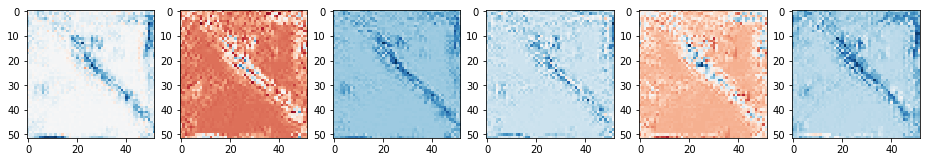

_feature 6 ReLU()


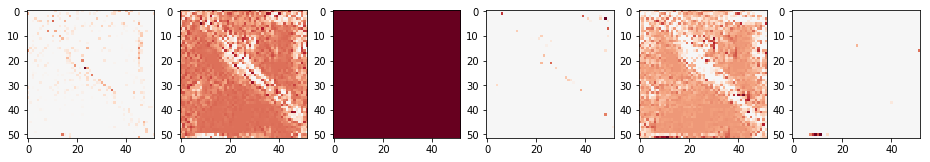

_feature 7 GeomConv2d(
  (conv2d): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
)


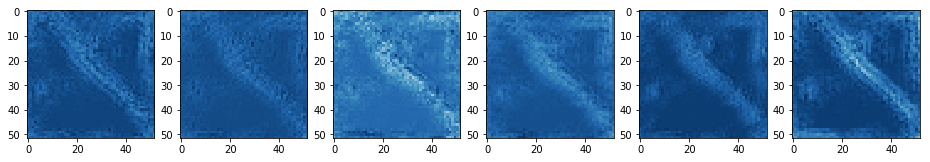

_feature 8 ReLU()


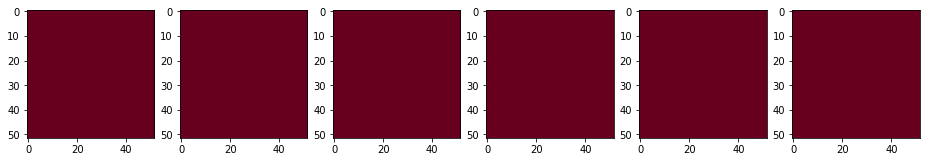

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


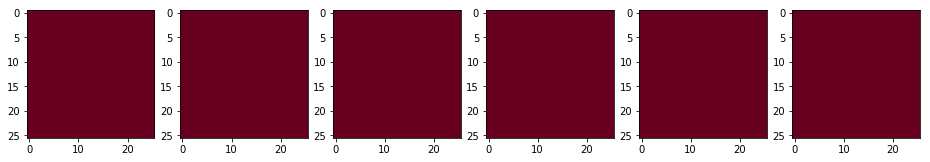

_feature 10 GeomConv2d(
  (conv2d): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
)


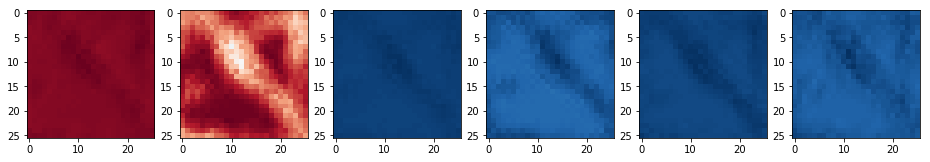

_feature 11 ReLU()


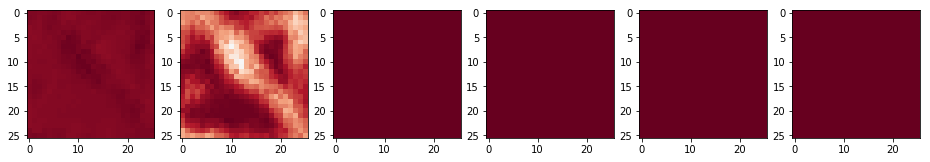

_feature 12 GeomConv2d(
  (conv2d): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
)


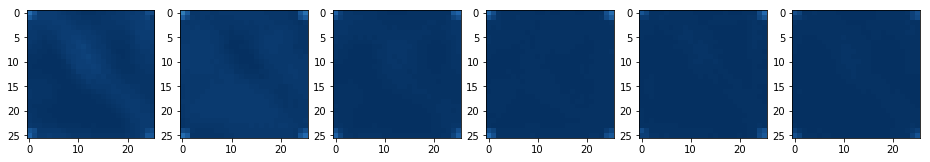

_feature 13 ReLU()


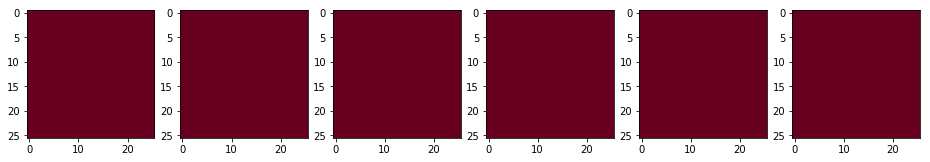

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


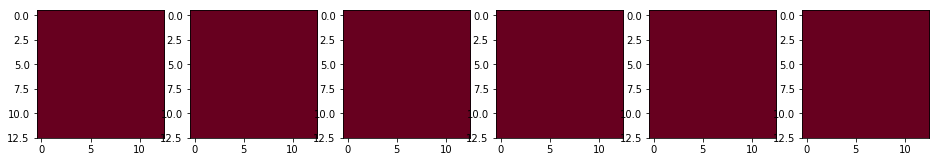

_feature 15 GeomConv2d(
  (conv2d): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
)


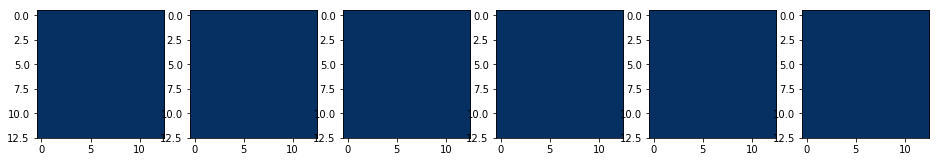

_feature 16 ReLU()


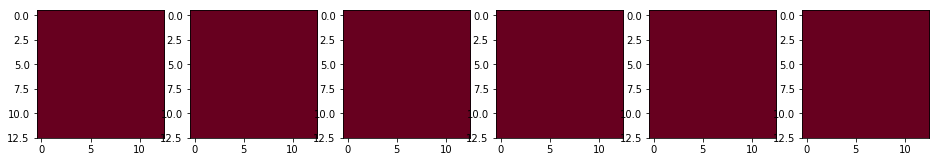

_feature 17 GeomConv2d(
  (conv2d): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
)


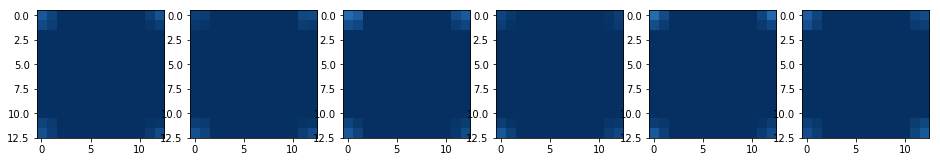

_feature 18 ReLU()


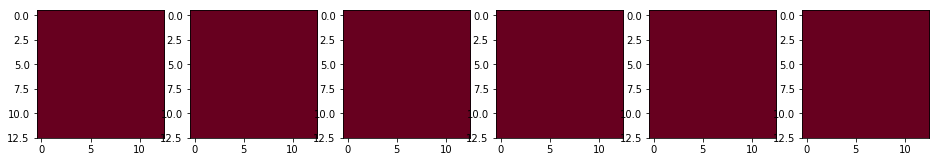

_feature 19 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


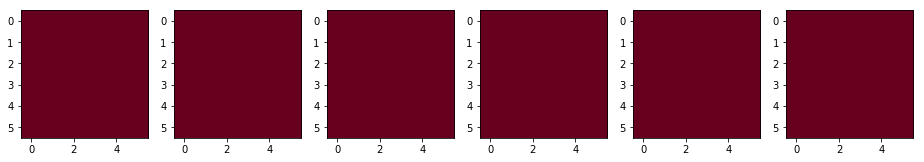

_feature 20 GeomConv2d(
  (conv2d): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
)


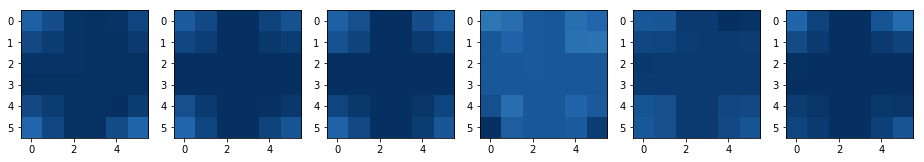

_feature 21 ReLU()


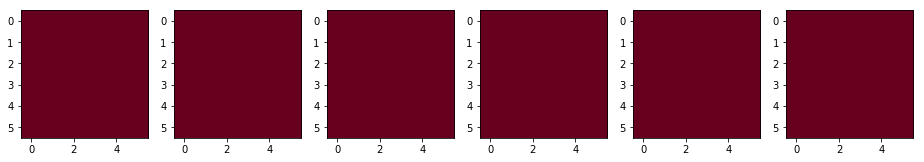

_feature 22 GeomConv2d(
  (conv2d): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
)


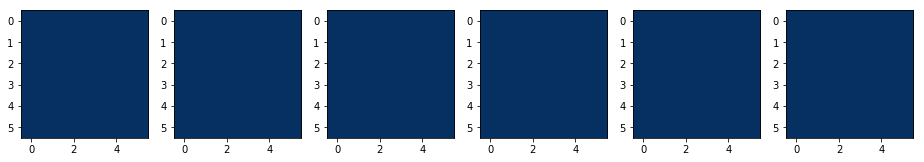

_feature 23 ReLU()


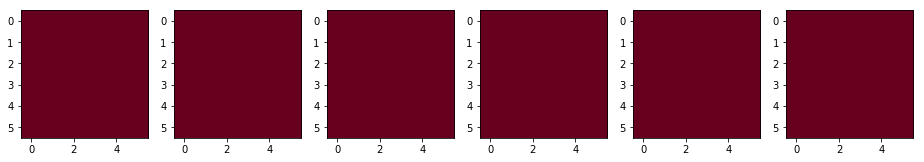

torch.Size([200, 256, 6, 6]) after _feature
torch.Size([200, 256, 1, 1]) after AvgPool2d
torch.Size([200, 256]) after view


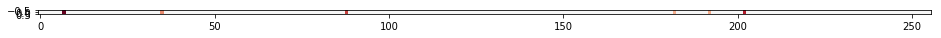

_classifier 0 Linear(in_features=256, out_features=128, bias=True)


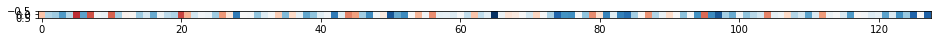

_classifier 1 ReLU()


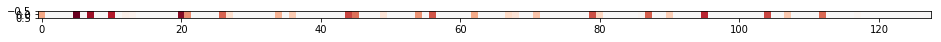

_classifier 2 Linear(in_features=128, out_features=3, bias=True)


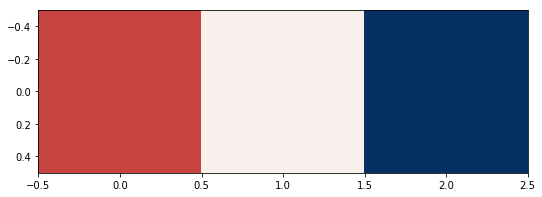

In [60]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    im = ax1.imshow(data[ev,1,:,:].cpu())
    cbar = ax1.figure.colorbar(im, ax=ax1)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        x = module(x)
        fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,0,:,:].cpu())
        imshowRdBu(ax1, x[ev,1,:,:].cpu())
        imshowRdBu(ax2, x[ev,2,:,:].cpu())
        imshowRdBu(ax3, x[ev,3,:,:].cpu())
        imshowRdBu(ax4, x[ev,4,:,:].cpu())
        imshowRdBu(ax5, x[ev,5,:,:].cpu())
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,256)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

## remove large time values

In [67]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        event_data[:,:,1] = np.where(event_data[:,:,0] > 0., event_data[:,:,1]-900., 0.) # shift center
        event_data[:,:,1] = np.where(np.abs(event_data[:,:,1]) > 100., 0., event_data[:,:,1]) # remove large variance
        return event_data,label,idx
        #return fh['event_data'][entry_index],np.stack([np.sum(fh['energies'][entry_index,:])]),idx
        #labels = (fh['energies'][entry_index,0]>500.)-0
        #return fh['event_data'][entry_index],labels,idx

In [68]:
# also add more data

mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(20) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [69]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = GeomCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
#blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
#blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [70]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-18 14:44:32


Epoch 1 Starting @ 2019-08-18 14:45:20


Epoch 2 Starting @ 2019-08-18 14:46:09


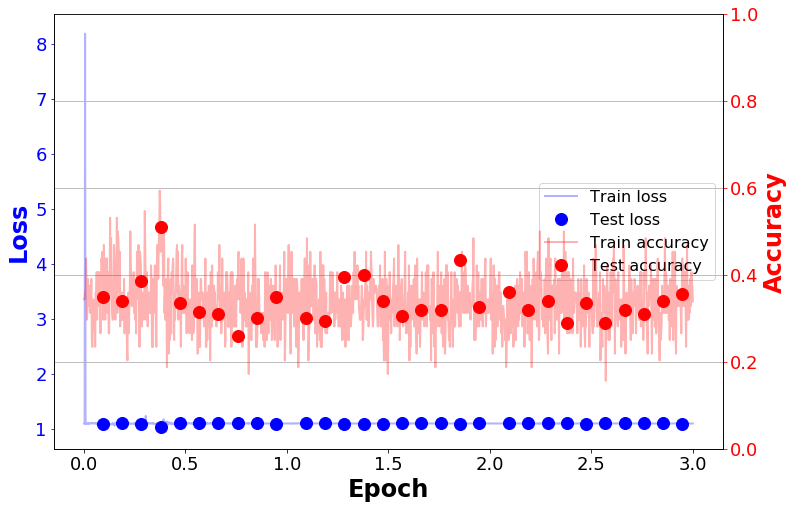

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

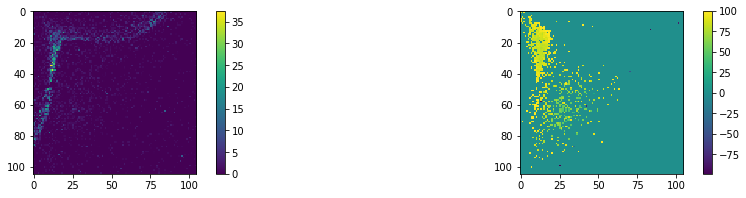

_feature 0 GeomConv2d(
  (conv2d): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
)


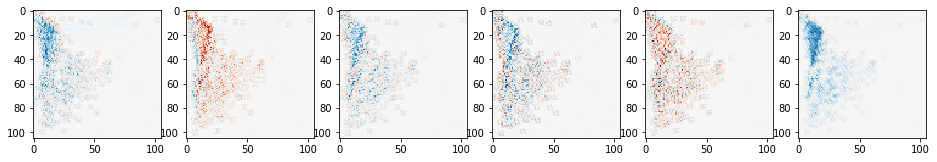

_feature 1 ReLU()


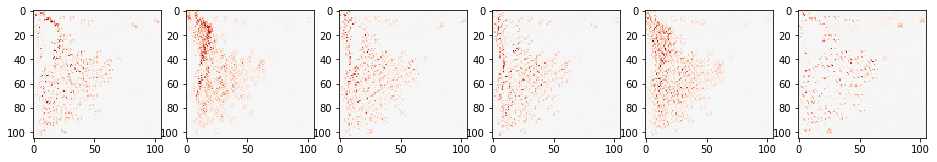

_feature 2 GeomConv2d(
  (conv2d): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
)


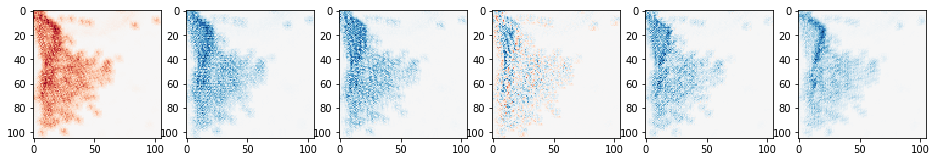

_feature 3 ReLU()


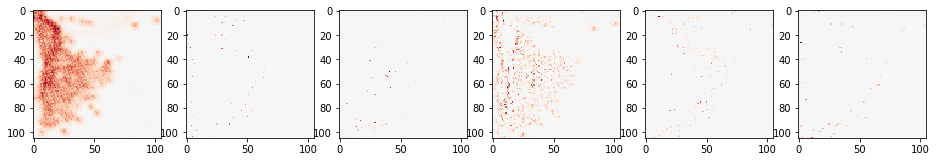

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


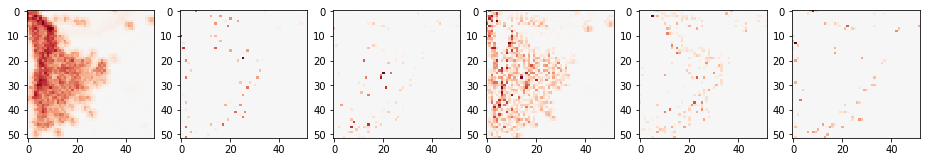

_feature 5 GeomConv2d(
  (conv2d): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
)


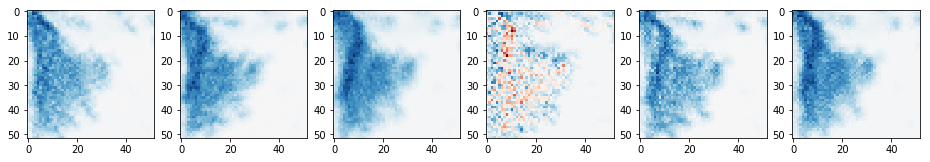

_feature 6 ReLU()


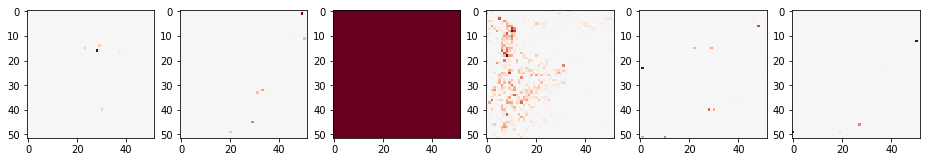

_feature 7 GeomConv2d(
  (conv2d): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
)


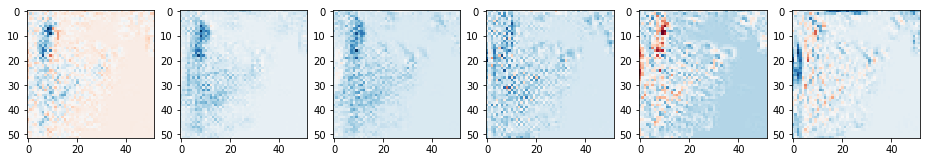

_feature 8 ReLU()


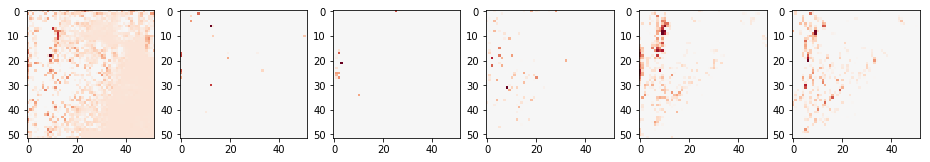

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


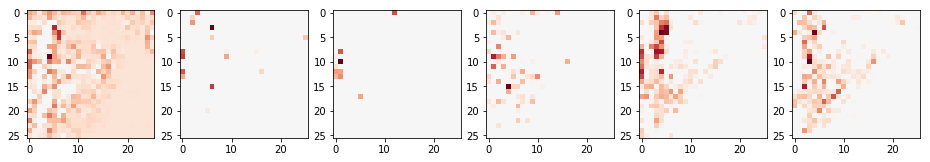

_feature 10 GeomConv2d(
  (conv2d): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
)


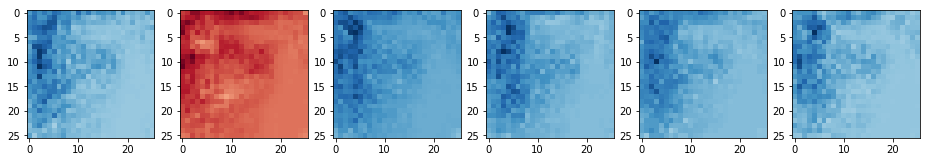

_feature 11 ReLU()


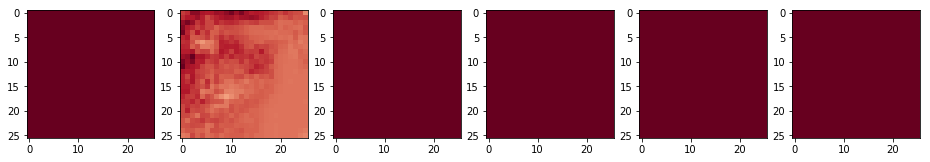

_feature 12 GeomConv2d(
  (conv2d): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
)


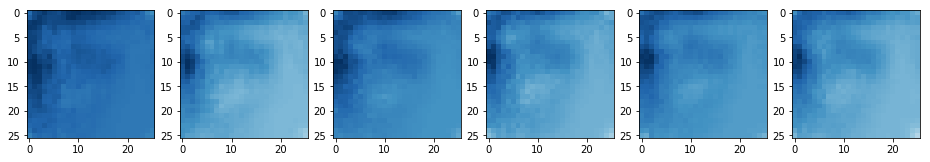

_feature 13 ReLU()


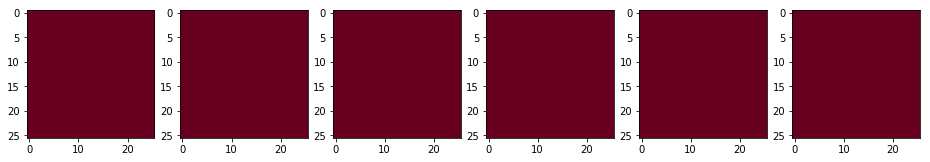

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


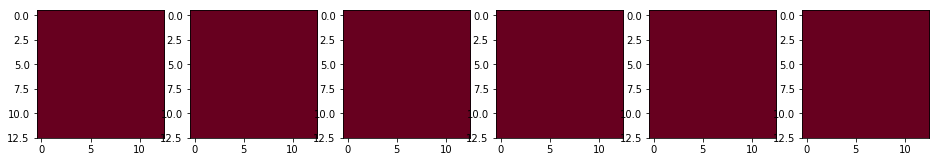

_feature 15 GeomConv2d(
  (conv2d): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
)


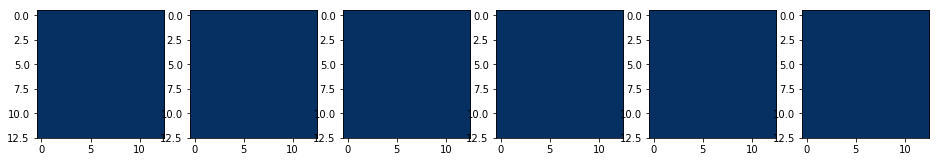

_feature 16 ReLU()


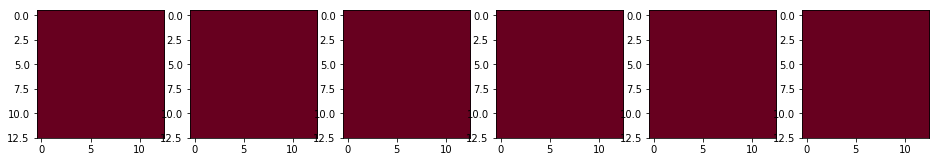

_feature 17 GeomConv2d(
  (conv2d): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
)


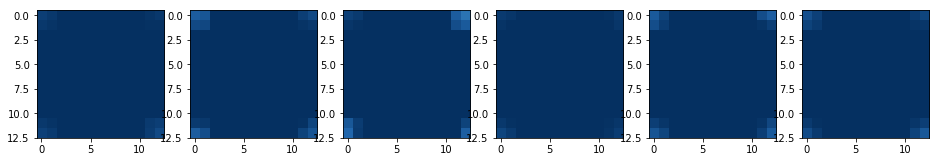

_feature 18 ReLU()


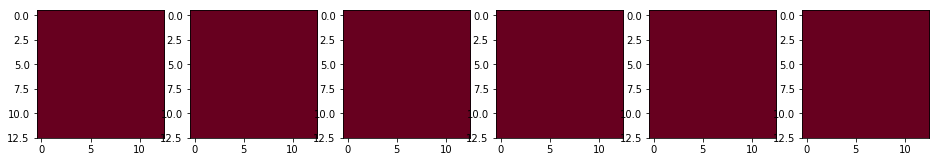

_feature 19 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


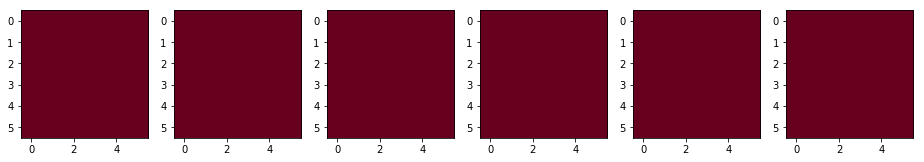

_feature 20 GeomConv2d(
  (conv2d): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
)


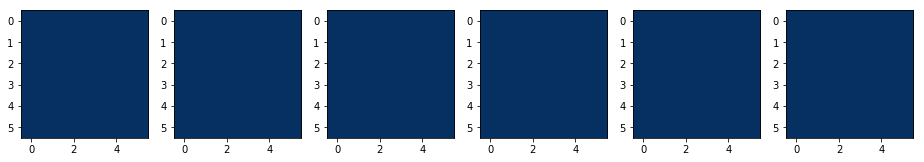

_feature 21 ReLU()


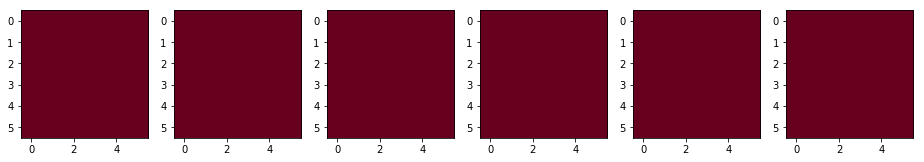

_feature 22 GeomConv2d(
  (conv2d): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
)


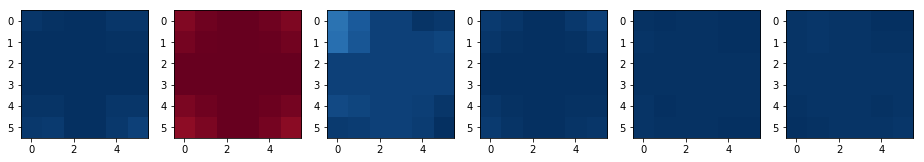

_feature 23 ReLU()


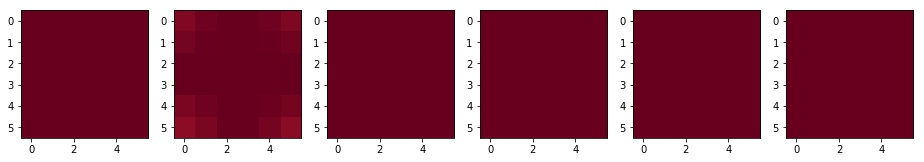

torch.Size([200, 256, 6, 6]) after _feature
torch.Size([200, 256, 1, 1]) after AvgPool2d
torch.Size([200, 256]) after view


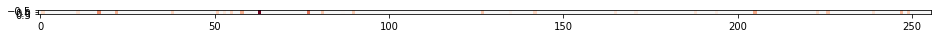

_classifier 0 Linear(in_features=256, out_features=128, bias=True)


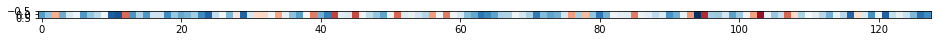

_classifier 1 ReLU()


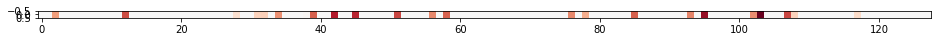

_classifier 2 Linear(in_features=128, out_features=3, bias=True)


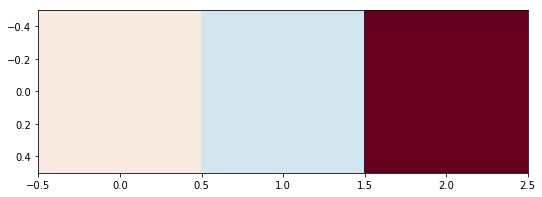

In [72]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    im = ax1.imshow(data[ev,1,:,:].cpu())
    cbar = ax1.figure.colorbar(im, ax=ax1)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        x = module(x)
        fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,0,:,:].cpu())
        imshowRdBu(ax1, x[ev,1,:,:].cpu())
        imshowRdBu(ax2, x[ev,2,:,:].cpu())
        imshowRdBu(ax3, x[ev,3,:,:].cpu())
        imshowRdBu(ax4, x[ev,4,:,:].cpu())
        imshowRdBu(ax5, x[ev,5,:,:].cpu())
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,256)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()